# Adaptive binned fit with hist PDF

In [1]:
import os
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

def set_style(tick_label_size=16, font_size=18):
    import matplotlib
    matplotlib.rc('xtick', labelsize=tick_label_size)
    matplotlib.rc('ytick', labelsize=tick_label_size)
    matplotlib.rc('font', size=font_size)

set_style()

In [2]:
from lib.params import mdn

In [3]:
data_path = './mcsamples'

In [4]:
def get_vars(data):
    """ """
    e, mddsq, md1pisq = [data[:,i] for i in range(3)]
    tdd = (np.sqrt(mddsq) - 2*mdn)*10**3
    mask = tdd > 0
    pd = np.sqrt(np.clip(tdd[mask], 0, None) * mdn * 10**3)
    return np.column_stack([e[mask], pd, np.sqrt(md1pisq[mask])])

In [5]:
def apply_range(data, rng):
    """ """
    for idx, (lo, hi) in enumerate(rng):
        data = data[(data[:,idx]>lo) & (data[:,idx]<hi)]
    return data

In [6]:
def smeared_sample(gsre, gsim, chunks, rng, N=-1, silent=True):
    fname = os.path.join(data_path, f'mc_ddpip_3d_gs{gsre:.2f}_{gsim:.2f}_ch{chunks}_smeared.npy')
    if not silent:
        print(fname)
    if os.path.isfile(fname) is None:
        return None
    return apply_range(get_vars(np.load(fname)), rng)[:N]

In [7]:
def find_bins(data, nbins):
    """ """
    x = np.sort(data)
    step = x.shape[0] // nbins
    return [x[i*step] for i in range(nbins)] + [x[-1]]

In [8]:
def adaptive_hist(ax, data, nbins):
    """ """
    ax.hist(data, bins=find_bins(data, nbins))

In [9]:
bins = (20,10,10)
edges = ((-1.5, 8.), (0, 120), (2.006, 2.014))

In [10]:
gsre0, gsim0, chunks0 = 41, 1.5, 50
test_sample = smeared_sample(gsre0, gsim0, chunks0, rng=edges)
test_sample.shape

(56630, 3)

In [11]:
test_sample[:5]

array([[-1.8318750e-01,  3.9051517e+01,  2.0085833e+00],
       [ 5.6085639e-02,  4.4605392e+01,  2.0094507e+00],
       [ 2.0143719e+00,  8.3349091e+01,  2.0103295e+00],
       [ 4.0795660e+00,  6.2979267e+01,  2.0127962e+00],
       [ 2.4006266e-02,  2.5311789e+01,  2.0091407e+00]], dtype=float32)

In [12]:
def draw_1d_projections(ax, data, bins, rng, weights=None):
    labels = [r'$E (MeV)$', r'$p(D^0)$ (MeV)', r'$m(D^0pi^+)$ (GeV)']
    for i in range(3):
        adaptive_hist(ax[i], data[:,i], bins[i])
        ax[i].set_xlim(rng[i])
        ax[i].grid()
        ax[i].set_xlabel(labels[i])

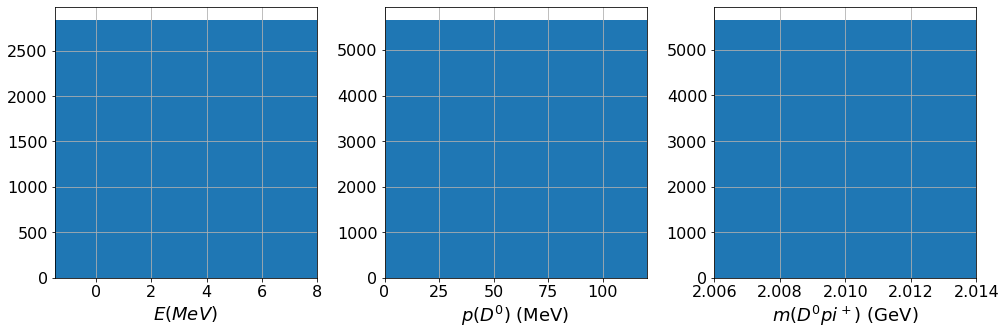

In [13]:
fig, ax = plt.subplots(ncols=3, figsize=(14,5))
draw_1d_projections(ax, test_sample, bins=bins, rng=edges)
fig.tight_layout()

In [14]:
def adaptive_binned_smeared_sample(gsre, gsim, chunks, bins, rng, N=-1, smpl=None):
    smpl = smeared_sample(gsre, gsim, chunks, rng, N)
    if smpl is None:
        return None
    if isinstance(bins[0], int):
        edges = [find_bins(smpl[:,i], b) for i, b in enumerate(bins)]
    else:
        edges = bins
    return np.histogramdd(smpl, bins=edges)

In [15]:
sample = smeared_sample(gsre0, gsim0, chunks0, rng=edges, N=5*10**4)
sample.shape

(50000, 3)

In [16]:
adahist_sample, ada_edges = adaptive_binned_smeared_sample(gsre0, gsim0, chunks0, bins, edges, N=5*10**4)

In [17]:
adahist_sample.shape

(20, 10, 10)

In [18]:
np.sum(adahist_sample)

50000.0

Most bins are not empty

In [19]:
np.sum(adahist_sample==0), np.sum(adahist_sample!=0)

(661, 1339)

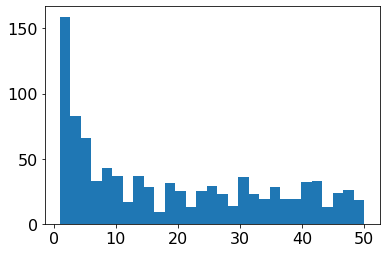

In [48]:
plt.hist(adahist_sample.flatten(), bins=29, range=(1, 50));

Chi2 fit cannot be used since most of bins contain zero or only a few events. Let't construct the Poisson binned likelihood function

$$
{\cal L} = \prod_i \frac{\mu_i^{n_i}e^{-\mu_i}}{n_i!}
$$

$$
{\cal F} = -\ln{\cal L}=-\sum_i\left(n_i\ln \mu_i - \mu_i - \ln (n_i!)\right)
$$

Second term in sum gives number of events in a tested sample $N$.

$$
{\cal F} = -\sum_i\left(n_i\ln \mu_i - \ln (n_i!)\right) + N
$$

In [21]:
def make_adaptive_reference(gsre, gsim, bins, rng):
    hist, edges = adaptive_binned_smeared_sample(gsre, gsim, chunks=250, bins=bins, rng=rng)
    if hist is None:
        return None
    return (hist / np.sum(hist), edges)

In [22]:
def apply_adaptive_bins(smpl, edges):
    """ """
    return np.histogramdd(smpl, bins=edges)[0]

In [23]:
from scipy.special import loggamma

In [24]:
def binned_loglh(hist, ref_hist):
    """ Binned log likelihood function """
    mask = ref_hist > 0
    n = hist[mask]
    n[n == 0] = 1
    N = np.sum(n)
    mu = ref_hist[mask] / np.sum(ref_hist) * N
    return -np.sum(n * np.log(mu) - loggamma(n)) + N

In [25]:
gsrel = [35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
gsiml = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]

In [26]:
mg_gsre, mg_gsim = np.meshgrid(gsrel, gsiml)
mg_gsre.shape

(9, 12)

In [27]:
def make_lhmap(samp, gsre, gsim, bins, rng, subtract_min=True):
    """ """
    lhmap = np.empty(gsre.shape)
    for i in range(lhmap.shape[0]):
        for j in range(lhmap.shape[1]):
            ada_reference, ada_edges = make_adaptive_reference(gsre[i,j], gsim[i,j], bins, rng)
            if ada_reference is None:
                print(f'reference not found for {mg_gsre[i,j]} {mg_gsim[i,j]}')
                lhmap[i,j] = -1
                continue
            ada_sample = apply_adaptive_bins(samp, ada_edges)
            lhmap[i,j] = binned_loglh(ada_sample, ada_reference)
    if subtract_min:
        lhmap -= np.min(lhmap)
    return lhmap

In [28]:
lhmap = make_lhmap(sample, mg_gsre, mg_gsim, bins, edges, subtract_min=True)
lhmap

array([[4326.66765647, 3048.1745043 , 2108.62821382, 1501.40936975,
         957.52636462,  616.0116537 ,  620.97873059,  732.20945596,
        1152.9492889 , 1806.80886777, 2651.49261542, 3845.94668667],
       [4081.32677042, 2854.9329553 , 1907.82490676, 1173.11205919,
         699.02594919,  369.25557521,  293.68712608,  454.2112426 ,
         989.54108753, 1484.11532853, 2345.98843158, 3446.6924174 ],
       [3683.68395135, 2646.3510958 , 1821.69288699,  982.31836888,
         532.81352981,  210.05765801,   95.47441069,  284.60214126,
         646.09640428, 1351.4186747 , 2200.63922385, 3298.34677883],
       [3468.11623616, 2477.5469931 , 1674.36531497,  960.79192382,
         442.20115907,  156.36437382,   53.87795917,  219.14977059,
         607.48295608, 1189.61331452, 1972.75005215, 3095.99928111],
       [3406.02516876, 2386.51821296, 1729.18887647,  836.74355887,
         420.77423512,  134.13350828,    0.        ,  180.75305811,
         514.99011416, 1111.95865511, 1939.1

In [60]:
def draw_spline_contours(ax, x, y, z, levels=10):
    f = interpolate.interp2d(x, y, z, kind='cubic')
#     f = interpolate.interp2d(x, y, z, kind='linear')
    newx = np.linspace(np.min(x), np.max(x), 50)
    newy = np.linspace(np.min(y), np.max(y), 50)
    cntf = ax.contourf(newx, newy, f(newx, newy), levels=levels);
    plt.colorbar(cntf, ax=ax);

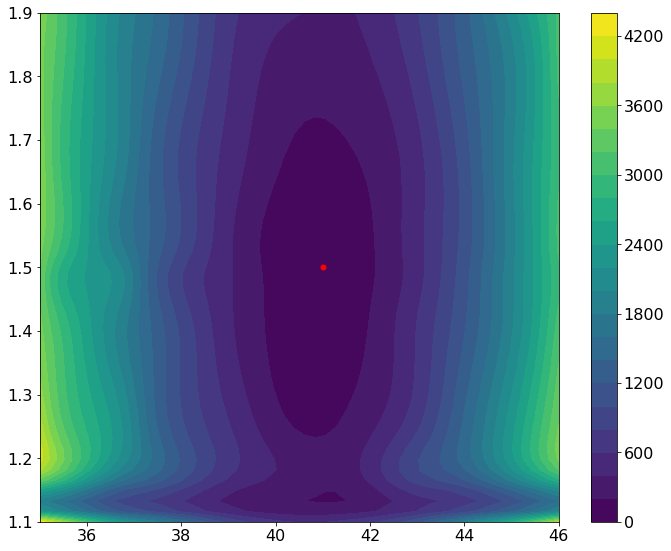

In [62]:
fig, ax = plt.subplots(figsize=(10,8))
draw_spline_contours(ax, mg_gsre, mg_gsim, lhmap, levels=25)
ax.plot([41], [1.5], marker='.', markersize=10, color='r');
fig.tight_layout()

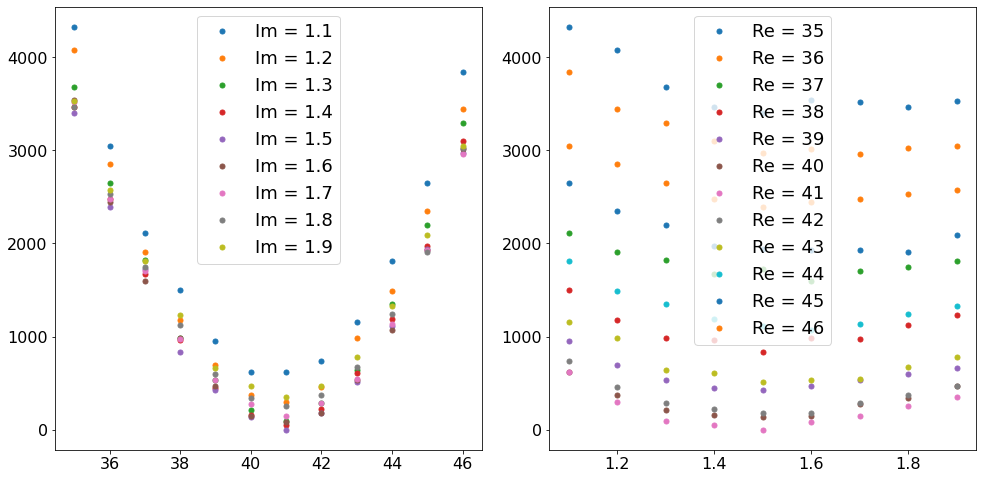

In [53]:
fig, ax = plt.subplots(ncols=2, figsize=(14,7))
for i in range(lhmap.shape[0]):
    ax[0].plot(gsrel, lhmap[i,:], linestyle='none', marker='.', markersize=10, label=f'Im = {gsiml[i]}')
    ax[0].legend()

for j in range(lhmap.shape[1]):
    ax[1].plot(gsiml, lhmap[:,j], linestyle='none', marker='.', markersize=10, label=f'Re = {gsrel[j]}');
    ax[1].legend()

fig.tight_layout()

Estimate of the statistical precision

In [32]:
lhmap.shape

(9, 12)

In [33]:
ilo, ihi = 1, 7
jlo, jhi = 5, 8
lhmap[ilo:ihi,jlo:jhi] - np.min(lhmap[ilo:ihi,jlo:jhi])

array([[369.25557521, 293.68712608, 454.2112426 ],
       [210.05765801,  95.47441069, 284.60214126],
       [156.36437382,  53.87795917, 219.14977059],
       [134.13350828,   0.        , 180.75305811],
       [150.76740209,  81.32281744, 183.62539781],
       [272.68149663, 143.36212096, 282.45606848]])

In [34]:
def parab(x, y, x0, y0, a, b, rho):
    """ """
    rot = np.array([
        [np.sqrt(1. - rho**2), -rho],
        [rho, np.sqrt(1. - rho**2)]
    ])
    xpr = (x - x0) * rot[0,0] + (y - y0) * rot[0, 1]
    ypr = (x - x0) * rot[1,0] + (y - y0) * rot[1, 1]
    return (xpr / a)**2 + (ypr / b)**2

In [35]:
def plot_parab(ax, x0, y0, a, b, rho):
    x = np.linspace(x0 - 10*a, x0 + 10*a, 100)
    y = np.linspace(y0 - 10*b, y0 + 10*b, 100)
    xl, yl = np.meshgrid(x, y)
    z = lambda x, y: parab(x, y, x0, y0, a, b, rho)
    return ax.contourf(xl, yl, z(xl, yl), levels=10)

In [36]:
ilo, ihi = 2, -1
jlo, jhi = 2, -1
xfit, yfit = np.meshgrid(gsrel[ilo:ihi], gsiml[jlo:jhi])
zfit = lhmap[ilo:ihi,jlo:jhi] - np.min(lhmap[ilo:ihi,jlo:jhi])
xfit.shape, yfit.shape, zfit.shape

((6, 9), (6, 9), (6, 9))

In [37]:
xfit

array([[37, 38, 39, 40, 41, 42, 43, 44, 45],
       [37, 38, 39, 40, 41, 42, 43, 44, 45],
       [37, 38, 39, 40, 41, 42, 43, 44, 45],
       [37, 38, 39, 40, 41, 42, 43, 44, 45],
       [37, 38, 39, 40, 41, 42, 43, 44, 45],
       [37, 38, 39, 40, 41, 42, 43, 44, 45]])

In [38]:
yfit

array([[1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3],
       [1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4],
       [1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5],
       [1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6],
       [1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7],
       [1.8, 1.8, 1.8, 1.8, 1.8, 1.8, 1.8, 1.8, 1.8]])

In [39]:
zfit

array([[1821.69288699,  982.31836888,  532.81352981,  210.05765801,
          95.47441069,  284.60214126,  646.09640428, 1351.4186747 ,
        2200.63922385],
       [1674.36531497,  960.79192382,  442.20115907,  156.36437382,
          53.87795917,  219.14977059,  607.48295608, 1189.61331452,
        1972.75005215],
       [1729.18887647,  836.74355887,  420.77423512,  134.13350828,
           0.        ,  180.75305811,  514.99011416, 1111.95865511,
        1939.19575079],
       [1593.94299199,  982.82847538,  473.21373244,  150.76740209,
          81.32281744,  183.62539781,  529.14779879, 1066.10426418,
        1930.59123715],
       [1702.60353369,  975.29821736,  532.12186611,  272.68149663,
         143.36212096,  282.45606848,  545.06820494, 1131.5239827 ,
        1934.21050665],
       [1748.63980347, 1127.13585632,  602.0760435 ,  340.99858463,
         256.00920182,  371.1405095 ,  669.54932032, 1237.52157522,
        1906.36001483]])

In [40]:
def loss(pars):
    x0, y0, a, b, rho = pars
    rho = max(min(rho, 0.99), -0.99)
    return np.sum((zfit - parab(xfit, yfit, x0, y0, a, b, rho))**2)

In [41]:
from scipy.optimize import minimize

In [42]:
init = (41, 1.5, 0.1, 0.1, 0.)
res = minimize(loss, init)
res

      fun: 148986.4664857279
 hess_inv: array([[ 6.44976738e-09, -6.11485943e-09, -2.09935766e-10,
        -1.39992431e-10,  3.06279375e-09],
       [-6.11485943e-09,  5.82937138e-09,  1.79494236e-10,
         1.31951441e-10, -2.92442765e-09],
       [-2.09935766e-10,  1.79494236e-10,  3.38423619e-11,
        -2.29818580e-11, -5.03113590e-11],
       [-1.39992431e-10,  1.31951441e-10, -2.29818580e-11,
         1.09252571e-10, -1.61072229e-10],
       [ 3.06279375e-09, -2.92442765e-09, -5.03113590e-11,
        -1.61072229e-10,  1.57102351e-09]])
      jac: array([ 0.01367188,  0.02148438,  0.11914062,  0.06445312, -0.00195312])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 617
      nit: 23
     njev: 101
   status: 2
  success: False
        x: array([ 4.08526743e+01,  1.53941401e+00,  9.53196535e-02,  1.86443527e-02,
       -1.00629493e-02])

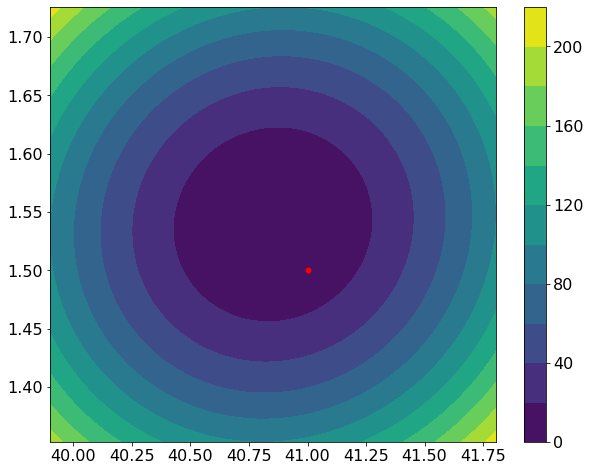

In [43]:
fig, ax = plt.subplots(figsize=(10,8))
cnt = plot_parab(ax, *res.x)
ax.plot([41], [1.5], marker='.', markersize=10, color='r');
plt.colorbar(cnt);

In [44]:
covar = np.diagonal(res.hess_inv)
np.sqrt(covar)

array([8.03104438e-05, 7.63503201e-05, 5.81741883e-06, 1.04523955e-05,
       3.96361389e-05])

In [45]:
sigmas = np.sqrt(covar) * np.sqrt(5*10**4)
sigmas

array([0.01795796, 0.01707245, 0.00130081, 0.00233723, 0.00886291])

In [63]:
print(f's(gamma_re) = {sigmas[0]*10**3:.1f} / sqrt(N) MeV')
print(f's(gamma_im) = {sigmas[1]*10**3:.1f} / sqrt(N) MeV')

s(gamma_re) = 18.0 / sqrt(N) MeV
s(gamma_im) = 17.1 / sqrt(N) MeV


For 400 events:

In [64]:
nevents = 400
print(f's(gamma_re) = {sigmas[0]/np.sqrt(nevents)*10**3:.1f} MeV @ {nevents} events')
print(f's(gamma_im) = {sigmas[1]/np.sqrt(nevents)*10**3:.1f} MeV @ {nevents} events')

s(gamma_re) = 0.9 MeV @ 400 events
s(gamma_im) = 0.9 MeV @ 400 events
